#analisis de relacion crimen san jose y metereologia de san jose
aplicando regresion lineal y posible arbol de decision se busca analisar las probabilidades de crimen para ciertas temperaturas
##posibles consideraciones
- dataframe de crimen descargado de las estadisticas de OIJ
- metereologia historica y estadisticas de los años 2020 al 2025, descargado de una pagina de clima
- se debio filtar, limpiar y unir los dos dataframe de forma que las temperaturas e informacion del tiempo sea proporcional al dia del delito

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



#carga de dataframe
para los 2 dataframe de estadisticas de oij llamado Estadisticas
se debera cambiar la columna fecha por Date de forma que se cumpla el merge


In [ ]:
# Leer el archivo
df_crime = pd.read_csv('sample_data/Estadisticas.csv')
print(df_crime.head())

   Delito    SubDelito       Fecha              Victima   SubVictima  \
0  ASALTO  ARMA BLANCA  2020-01-25  18:00:00 - 20:59:59  EDIFICACION   
1  ASALTO  ARMA BLANCA  2020-04-18  18:00:00 - 20:59:59  EDIFICACION   
2  ASALTO  ARMA BLANCA  2020-05-21  06:00:00 - 08:59:59  EDIFICACION   
3  ASALTO  ARMA BLANCA  2020-06-03  06:00:00 - 08:59:59  EDIFICACION   
4  ASALTO  ARMA BLANCA  2020-07-13  09:00:00 - 11:59:59  EDIFICACION   

                             Edad           Sexo Nacionalidad    Provincia  \
0       GASOLINERIA [EDIFICACION]  Mayor de edad        MUJER   COSTA RICA   
1  RESTAURANTE/SODA [EDIFICACION]  Mayor de edad       HOMBRE   COSTA RICA   
2     SUPER MERCADO [EDIFICACION]    Desconocido  DESCONOCIDO   COSTA RICA   
3         PANADERIA [EDIFICACION]    Desconocido  DESCONOCIDO  Desconocido   
4  RESTAURANTE/SODA [EDIFICACION]  Mayor de edad        MUJER   COSTA RICA   

     Canton       Distrito  Unnamed: 11  
0     LIMON          LIMON          NaN  
1  SAN JOSE   

#Carga del dataframe de metereologia
filtrado, limpiado para preparar el merge de los 2
data frame

In [ ]:
# Leer el archivo
df_meteo = pd.read_csv('sample_data/export-san-jose2020-2025 csv.csv')
# Mostrar las primeras filas
print(df_meteo.head())

         Date  MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  WINDSPEED_MAX_KMH  \
0  2020-01-01                 27                 13                  9   
1  2020-01-02                 26                 16                  7   
2  2020-01-03                 22                 13                  5   
3  2020-01-04                 26                 15                  8   
4  2020-01-05                 24                 15                 15   

   TEMPERATURE_MORNING_C_6H  TEMPERATURE_NOON_C_12H  \
0                        15                      27   
1                        16                      26   
2                        13                      22   
3                        15                      26   
4                        17                      24   

   TEMPERATURE_EVENING_C_18H  PRECIP_TOTAL_DAY_MM  HUMIDITY_MAX_PERCENT  \
0                         22                  0.1                    63   
1                         20                  1.9                    74   

#Validación de tipos
para corroborar que no haya discrepancias

In [ ]:
print(df_crime.dtypes)

Delito           object
SubDelito        object
Fecha            object
Victima          object
SubVictima       object
Edad             object
Sexo             object
Nacionalidad     object
Provincia        object
Canton           object
Distrito         object
Unnamed: 11     float64
dtype: object


In [ ]:
print(df_meteo.dtypes)

Date                          object
MAX_TEMPERATURE_C              int64
MIN_TEMPERATURE_C              int64
WINDSPEED_MAX_KMH              int64
TEMPERATURE_MORNING_C_6H       int64
TEMPERATURE_NOON_C_12H         int64
TEMPERATURE_EVENING_C_18H      int64
PRECIP_TOTAL_DAY_MM          float64
HUMIDITY_MAX_PERCENT           int64
VISIBILITY_AVG_KM            float64
PRESSURE_MAX_MB                int64
CLOUDCOVER_AVG_PERCENT       float64
HEATINDEX_MAX_C                int64
DEWPOINT_MAX_C                 int64
WINDTEMP_MAX_C                 int64
WEATHER_CODE_MORNING_6H        int64
WEATHER_CODE_NOON_12H          int64
WEATHER_CODE_EVENING_18H       int64
TOTAL_SNOW_MM                  int64
UV_INDEX                       int64
SUNHOUR                      float64
OPINION                       object
SUNSET                        object
SUNRISE                       object
TEMPERATURE_NIGHT_C_3H         int64
WEATHER_CODE_NIGHT_3H          int64
TEMPERATURE_9H                 int64
W

#seleccion de columnas a usar
para las columnas:
- Delito
- SubDelito
- Fecha
- SubVictima
- Sexo
- Provincia
- Canton
- Distrito


In [ ]:
# Seleccionar las columnas de interés
selected_columns_df_crime = df_crime[['Delito', 'SubDelito', 'Fecha', 'Edad','Victima','SubVictima','Sexo', 'Provincia', 'Canton', 'Distrito', 'Edad', 'Nacionalidad']]
print(selected_columns_df_crime.head())

   Delito    SubDelito       Fecha                            Edad  \
0  ASALTO  ARMA BLANCA  2020-01-25       GASOLINERIA [EDIFICACION]   
1  ASALTO  ARMA BLANCA  2020-04-18  RESTAURANTE/SODA [EDIFICACION]   
2  ASALTO  ARMA BLANCA  2020-05-21     SUPER MERCADO [EDIFICACION]   
3  ASALTO  ARMA BLANCA  2020-06-03         PANADERIA [EDIFICACION]   
4  ASALTO  ARMA BLANCA  2020-07-13  RESTAURANTE/SODA [EDIFICACION]   

               Victima   SubVictima           Sexo    Provincia    Canton  \
0  18:00:00 - 20:59:59  EDIFICACION  Mayor de edad   COSTA RICA     LIMON   
1  18:00:00 - 20:59:59  EDIFICACION  Mayor de edad   COSTA RICA  SAN JOSE   
2  06:00:00 - 08:59:59  EDIFICACION    Desconocido   COSTA RICA  SAN JOSE   
3  06:00:00 - 08:59:59  EDIFICACION    Desconocido  Desconocido  SAN JOSE   
4  09:00:00 - 11:59:59  EDIFICACION  Mayor de edad   COSTA RICA  ALAJUELA   

        Distrito                            Edad Nacionalidad  
0          LIMON       GASOLINERIA [EDIFICACION]    

# verificacion de valores faltantes
para el data frame de estadisticas

In [ ]:
# Verificar valores faltantes
missing_values_df_crime = selected_columns_df_crime.isnull().sum()
print(missing_values_df_crime)

Delito          0
SubDelito       0
Fecha           0
Victima         0
SubVictima      0
Sexo            0
Provincia       0
Canton          0
Distrito        0
Edad            0
Nacionalidad    0
dtype: int64


# filtrado
para que el data framme aparezca solo en el canton san jose de costa rica

In [ ]:
filtrer_df_crime = df_crime[df_crime['Canton'] == 'SAN JOSE']
print(filtrer_df_crime.head())

    Delito    SubDelito       Fecha              Victima   SubVictima  \
1   ASALTO  ARMA BLANCA  2020-04-18  18:00:00 - 20:59:59  EDIFICACION   
2   ASALTO  ARMA BLANCA  2020-05-21  06:00:00 - 08:59:59  EDIFICACION   
3   ASALTO  ARMA BLANCA  2020-06-03  06:00:00 - 08:59:59  EDIFICACION   
6   ASALTO  ARMA BLANCA  2020-10-17  15:00:00 - 17:59:59  EDIFICACION   
10  ASALTO  ARMA BLANCA  2021-02-07  09:00:00 - 11:59:59  EDIFICACION   

                                                 Edad           Sexo  \
1                      RESTAURANTE/SODA [EDIFICACION]  Mayor de edad   
2                         SUPER MERCADO [EDIFICACION]    Desconocido   
3                             PANADERIA [EDIFICACION]    Desconocido   
6                       TIENDA/BOUTIQUE [EDIFICACION]  Mayor de edad   
10  PULPERIA/ABASTECEDOR/MINISUPER/EXPENDIO CARNE ...  Mayor de edad   

   Nacionalidad    Provincia    Canton       Distrito  Unnamed: 11  
1        HOMBRE   COSTA RICA  SAN JOSE   DESAMPARADOS      

# filtrado
del data frame original sin valores faltantes

In [ ]:
# Seleccionar las columnas de interés
selected_columns_df_crime = filtrer_df_crime[['Delito', 'SubDelito', 'Fecha','Edad' ,'Victima','SubVictima','Sexo', 'Provincia', 'Canton', 'Distrito']]
print(selected_columns_df_crime.head())

    Delito    SubDelito       Fecha  \
1   ASALTO  ARMA BLANCA  2020-04-18   
2   ASALTO  ARMA BLANCA  2020-05-21   
3   ASALTO  ARMA BLANCA  2020-06-03   
6   ASALTO  ARMA BLANCA  2020-10-17   
10  ASALTO  ARMA BLANCA  2021-02-07   

                                                 Edad              Victima  \
1                      RESTAURANTE/SODA [EDIFICACION]  18:00:00 - 20:59:59   
2                         SUPER MERCADO [EDIFICACION]  06:00:00 - 08:59:59   
3                             PANADERIA [EDIFICACION]  06:00:00 - 08:59:59   
6                       TIENDA/BOUTIQUE [EDIFICACION]  15:00:00 - 17:59:59   
10  PULPERIA/ABASTECEDOR/MINISUPER/EXPENDIO CARNE ...  09:00:00 - 11:59:59   

     SubVictima           Sexo    Provincia    Canton       Distrito  
1   EDIFICACION  Mayor de edad   COSTA RICA  SAN JOSE   DESAMPARADOS  
2   EDIFICACION    Desconocido   COSTA RICA  SAN JOSE  PEREZ ZELEDON  
3   EDIFICACION    Desconocido  Desconocido  SAN JOSE       SAN JOSE  
6   EDIFICAC

# Lectura de tipos
del data frame de metereologia para verificar posibles valores que no debian ser tipos diferentes al que se ocupaba

In [ ]:
print(df_meteo.dtypes)

Date                          object
MAX_TEMPERATURE_C              int64
MIN_TEMPERATURE_C              int64
WINDSPEED_MAX_KMH              int64
TEMPERATURE_MORNING_C_6H       int64
TEMPERATURE_NOON_C_12H         int64
TEMPERATURE_EVENING_C_18H      int64
PRECIP_TOTAL_DAY_MM          float64
HUMIDITY_MAX_PERCENT           int64
VISIBILITY_AVG_KM            float64
PRESSURE_MAX_MB                int64
CLOUDCOVER_AVG_PERCENT       float64
HEATINDEX_MAX_C                int64
DEWPOINT_MAX_C                 int64
WINDTEMP_MAX_C                 int64
WEATHER_CODE_MORNING_6H        int64
WEATHER_CODE_NOON_12H          int64
WEATHER_CODE_EVENING_18H       int64
TOTAL_SNOW_MM                  int64
UV_INDEX                       int64
SUNHOUR                      float64
OPINION                       object
SUNSET                        object
SUNRISE                       object
TEMPERATURE_NIGHT_C_3H         int64
WEATHER_CODE_NIGHT_3H          int64
TEMPERATURE_9H                 int64
W

# filtrado
para guardar solo colummnas:
- Date
- MAX_TEMPERATURE_C
- MIN_TEMPERATURE_C
- HUMIDITY_MAX_PERCENT
- TEMPERATURE_MORNING_C_6H
- TEMPERATURE_NOON_C_12H
- TEMPERATURE_EVENING_C_18H
- PRECIP_TOTAL_DAY_MM
- TOTAL_SNOW_MM
- WINDTEMP_MAX_C
- WINDSPEED_MAX_KMH
- VISIBILITY_AVG_KM
- PRESSURE_MAX_MB
- CLOUDCOVER_AVG_PERCENT
- UV_INDEX
- SUNHOUR

In [ ]:
# Seleccionar las columnas de interés
selected_columns_df_meteo = df_meteo[['Date', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'HUMIDITY_MAX_PERCENT', 'TEMPERATURE_MORNING_C_6H',
                                      'TEMPERATURE_NOON_C_12H', 'TEMPERATURE_EVENING_C_18H', 'PRECIP_TOTAL_DAY_MM', 'TOTAL_SNOW_MM',
                                      'WINDTEMP_MAX_C', 'WINDSPEED_MAX_KMH', 'VISIBILITY_AVG_KM', 'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT',
                                      'UV_INDEX', 'SUNHOUR']]
print(selected_columns_df_meteo.head())

         Date  MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  HUMIDITY_MAX_PERCENT  \
0  2020-01-01                 27                 13                    63   
1  2020-01-02                 26                 16                    74   
2  2020-01-03                 22                 13                    97   
3  2020-01-04                 26                 15                    97   
4  2020-01-05                 24                 15                    92   

   TEMPERATURE_MORNING_C_6H  TEMPERATURE_NOON_C_12H  \
0                        15                      27   
1                        16                      26   
2                        13                      22   
3                        15                      26   
4                        17                      24   

   TEMPERATURE_EVENING_C_18H  PRECIP_TOTAL_DAY_MM  TOTAL_SNOW_MM  \
0                         22                  0.1              0   
1                         20                  1.9              0   
2 

# valores faltantes
para validar el dataframe tenga toda la informacion previo al analisis

In [ ]:
# Verificar valores faltantes
missing_values_df_meteo = selected_columns_df_meteo.isnull().sum()
print(missing_values_df_meteo)

Date                         0
MAX_TEMPERATURE_C            0
MIN_TEMPERATURE_C            0
HUMIDITY_MAX_PERCENT         0
TEMPERATURE_MORNING_C_6H     0
TEMPERATURE_NOON_C_12H       0
TEMPERATURE_EVENING_C_18H    0
PRECIP_TOTAL_DAY_MM          0
TOTAL_SNOW_MM                0
WINDTEMP_MAX_C               0
WINDSPEED_MAX_KMH            0
VISIBILITY_AVG_KM            0
PRESSURE_MAX_MB              0
CLOUDCOVER_AVG_PERCENT       0
UV_INDEX                     0
SUNHOUR                      0
dtype: int64


# preparacion para unir dataframes
se debio cambiar los nombres de las columnas de Fecha a Date para poder usar el merge de pandas

In [ ]:
# Rename column 'Fecha' to 'Date'
selected_columns_df_crime = selected_columns_df_crime.rename(columns={'Fecha': 'Date'})

# Check the updated dataframe
print(selected_columns_df_crime.head())

    Delito    SubDelito        Date  \
1   ASALTO  ARMA BLANCA  2020-04-18   
2   ASALTO  ARMA BLANCA  2020-05-21   
3   ASALTO  ARMA BLANCA  2020-06-03   
6   ASALTO  ARMA BLANCA  2020-10-17   
10  ASALTO  ARMA BLANCA  2021-02-07   

                                                 Edad              Victima  \
1                      RESTAURANTE/SODA [EDIFICACION]  18:00:00 - 20:59:59   
2                         SUPER MERCADO [EDIFICACION]  06:00:00 - 08:59:59   
3                             PANADERIA [EDIFICACION]  06:00:00 - 08:59:59   
6                       TIENDA/BOUTIQUE [EDIFICACION]  15:00:00 - 17:59:59   
10  PULPERIA/ABASTECEDOR/MINISUPER/EXPENDIO CARNE ...  09:00:00 - 11:59:59   

     SubVictima           Sexo    Provincia    Canton       Distrito  
1   EDIFICACION  Mayor de edad   COSTA RICA  SAN JOSE   DESAMPARADOS  
2   EDIFICACION    Desconocido   COSTA RICA  SAN JOSE  PEREZ ZELEDON  
3   EDIFICACION    Desconocido  Desconocido  SAN JOSE       SAN JOSE  
6   EDIFICAC

In [ ]:
# Rename column 'Fecha' to 'Date'
selected_columns_df_crime = selected_columns_df_crime.rename(columns={'Fecha': 'Date'})

# Check the updated dataframe
print(selected_columns_df_meteo.head())

         Date  MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  HUMIDITY_MAX_PERCENT  \
0  2020-01-01                 27                 13                    63   
1  2020-01-02                 26                 16                    74   
2  2020-01-03                 22                 13                    97   
3  2020-01-04                 26                 15                    97   
4  2020-01-05                 24                 15                    92   

   TEMPERATURE_MORNING_C_6H  TEMPERATURE_NOON_C_12H  \
0                        15                      27   
1                        16                      26   
2                        13                      22   
3                        15                      26   
4                        17                      24   

   TEMPERATURE_EVENING_C_18H  PRECIP_TOTAL_DAY_MM  TOTAL_SNOW_MM  \
0                         22                  0.1              0   
1                         20                  1.9              0   
2 

# Aplicacion del merge
para juntar los 2 dataFrames

In [ ]:
merged_df = pd.merge(selected_columns_df_crime, selected_columns_df_meteo, on='Date', how='inner')  # Use 'left', 'right', or 'outer' depending on your needs

print(merged_df)


       Delito        SubDelito        Date  \
0      ASALTO      ARMA BLANCA  2020-04-18   
1      ASALTO      ARMA BLANCA  2020-05-21   
2      ASALTO      ARMA BLANCA  2020-06-03   
3      ASALTO      ARMA BLANCA  2020-10-17   
4      ASALTO      ARMA BLANCA  2021-02-07   
...       ...              ...         ...   
10117    ROBO  RUPTURA VENTANA  2022-02-03   
10118    ROBO  RUPTURA VENTANA  2022-08-31   
10119    ROBO  RUPTURA VENTANA  2022-12-22   
10120    ROBO  RUPTURA VENTANA  2024-01-29   
10121    ROBO  RUPTURA VENTANA  2024-07-24   

                                                    Edad              Victima  \
0                         RESTAURANTE/SODA [EDIFICACION]  18:00:00 - 20:59:59   
1                            SUPER MERCADO [EDIFICACION]  06:00:00 - 08:59:59   
2                                PANADERIA [EDIFICACION]  06:00:00 - 08:59:59   
3                          TIENDA/BOUTIQUE [EDIFICACION]  15:00:00 - 17:59:59   
4      PULPERIA/ABASTECEDOR/MINISUPER/EXPE

# Segundo día
por motivos de tiempo entre mi certificado, universidad y curso de ingles. debio ser un proyecto distribuido en dias

# Descarga de DataFrame
para poder manejar mejor el dataframe una vez convertido

In [ ]:
# guardado de data frame
merged_df.to_csv("meteo_sj_crime.csv", index=False)  # Guardar como CSV
merged_df.to_excel("meteo_sj_crime.xlsx", index=False)  # Guardar como Excel

#Carga de nuevo dataframe
para empezar analisis exploratorio

In [ ]:
# Leer el archivo
df_meteo_merge = pd.read_csv('sample_data/meteo_sj_crime.csv')
# Mostrar las primeras filas
print(df_meteo_merge.head())

   Delito    SubDelito        Date  \
0  ASALTO  ARMA BLANCA  2020-04-18   
1  ASALTO  ARMA BLANCA  2020-05-21   
2  ASALTO  ARMA BLANCA  2020-06-03   
3  ASALTO  ARMA BLANCA  2020-10-17   
4  ASALTO  ARMA BLANCA  2021-02-07   

                                                Edad              Victima  \
0                     RESTAURANTE/SODA [EDIFICACION]  18:00:00 - 20:59:59   
1                        SUPER MERCADO [EDIFICACION]  06:00:00 - 08:59:59   
2                            PANADERIA [EDIFICACION]  06:00:00 - 08:59:59   
3                      TIENDA/BOUTIQUE [EDIFICACION]  15:00:00 - 17:59:59   
4  PULPERIA/ABASTECEDOR/MINISUPER/EXPENDIO CARNE ...  09:00:00 - 11:59:59   

    SubVictima           Sexo    Provincia    Canton       Distrito  ...  \
0  EDIFICACION  Mayor de edad   COSTA RICA  SAN JOSE   DESAMPARADOS  ...   
1  EDIFICACION    Desconocido   COSTA RICA  SAN JOSE  PEREZ ZELEDON  ...   
2  EDIFICACION    Desconocido  Desconocido  SAN JOSE       SAN JOSE  ...   
3  E

In [ ]:
# useful for plotting later on
years = list(map(str, range(2020, 2025)))
years

['2020', '2021', '2022', '2023', '2024']

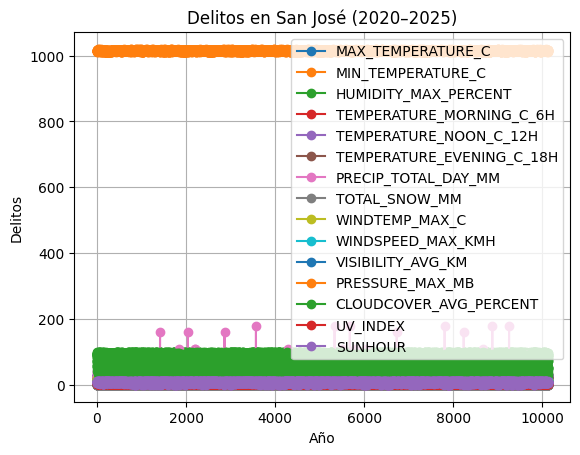

In [ ]:
df_meteo_merge.plot(kind='line', marker='o')
plt.title('Delitos en San José (2020–2025)')
plt.xlabel('Año')
plt.ylabel('Delitos')
plt.grid(True)
plt.show()


Text(0.5, 0, 'SubDelito')

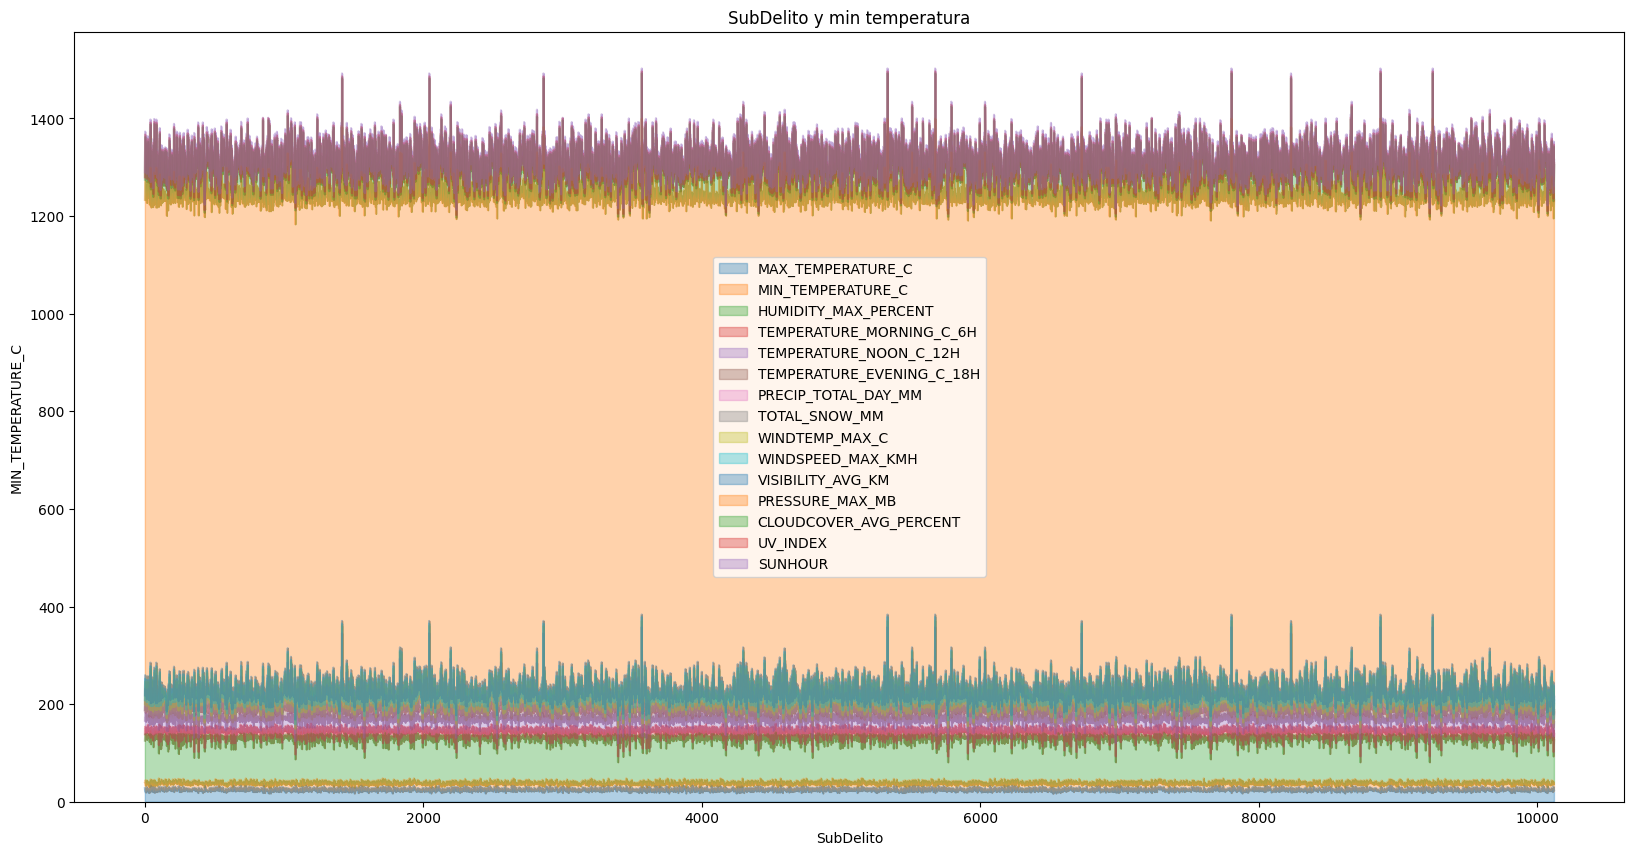

In [ ]:
# option 2: preferred option with more flexibility
ax = df_meteo_merge.plot(kind='area', alpha=0.35, figsize=(20, 10))

ax.set_title('SubDelito y min temperatura')
ax.set_ylabel('MIN_TEMPERATURE_C')
ax.set_xlabel('SubDelito')

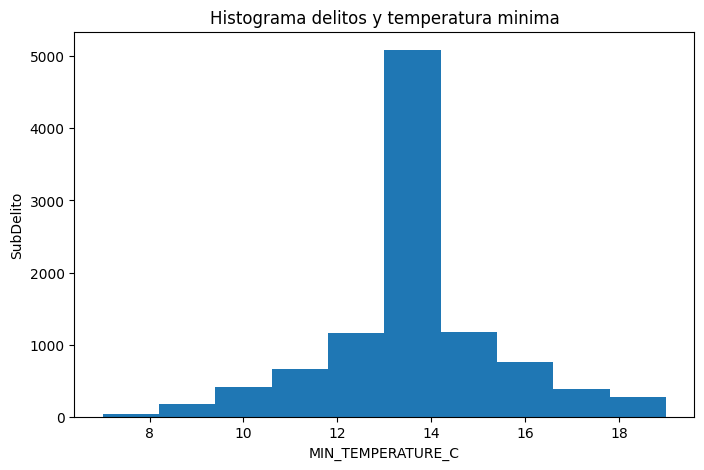

In [ ]:
df_meteo_merge['MIN_TEMPERATURE_C'].plot(kind='hist', figsize=(8, 5))
# add a title to the histogram
plt.title('Histograma delitos y temperatura minima')
# add y-label
plt.ylabel('SubDelito')
# add x-label
plt.xlabel('MIN_TEMPERATURE_C')
plt.show()

In [ ]:
df_meteo_merge['Delito'] = df_meteo_merge['Delito'].astype('category').cat.codes
df_meteo_merge['SubDelito'] = df_meteo_merge['SubDelito'].astype('category').cat.codes
df_meteo_merge['Distrito'] = df_meteo_merge['Distrito'].astype('category').cat.codes
df_meteo_merge['Sexo'] = df_meteo_merge['Sexo'].astype('category').cat.codes
df_meteo_merge['Victima'] = df_meteo_merge['Victima'].astype('category').cat.codes
df_meteo_merge['Edad'] = df_meteo_merge['Edad'].astype('category').cat.codes
df_meteo_merge['Date'] = df_meteo_merge['Date'].astype('category').cat.codes
df_meteo_merge['SubVictima'] = df_meteo_merge['SubVictima'].astype('category').cat.codes

# corroboracion
de tipos para evitar problemas proximos y validar conversiones categoricas

In [ ]:
print(df_meteo_merge.dtypes)

Delito                          int8
SubDelito                       int8
Date                           int16
Edad                            int8
Victima                         int8
SubVictima                      int8
Sexo                            int8
Provincia                     object
Canton                        object
Distrito                        int8
MAX_TEMPERATURE_C              int64
MIN_TEMPERATURE_C              int64
HUMIDITY_MAX_PERCENT           int64
TEMPERATURE_MORNING_C_6H       int64
TEMPERATURE_NOON_C_12H         int64
TEMPERATURE_EVENING_C_18H      int64
PRECIP_TOTAL_DAY_MM          float64
TOTAL_SNOW_MM                  int64
WINDTEMP_MAX_C                 int64
WINDSPEED_MAX_KMH              int64
VISIBILITY_AVG_KM            float64
PRESSURE_MAX_MB                int64
CLOUDCOVER_AVG_PERCENT       float64
UV_INDEX                       int64
SUNHOUR                      float64
dtype: object


# Creacion de caracteristicas
para analizar el primer arbol de prueba y correlaciones

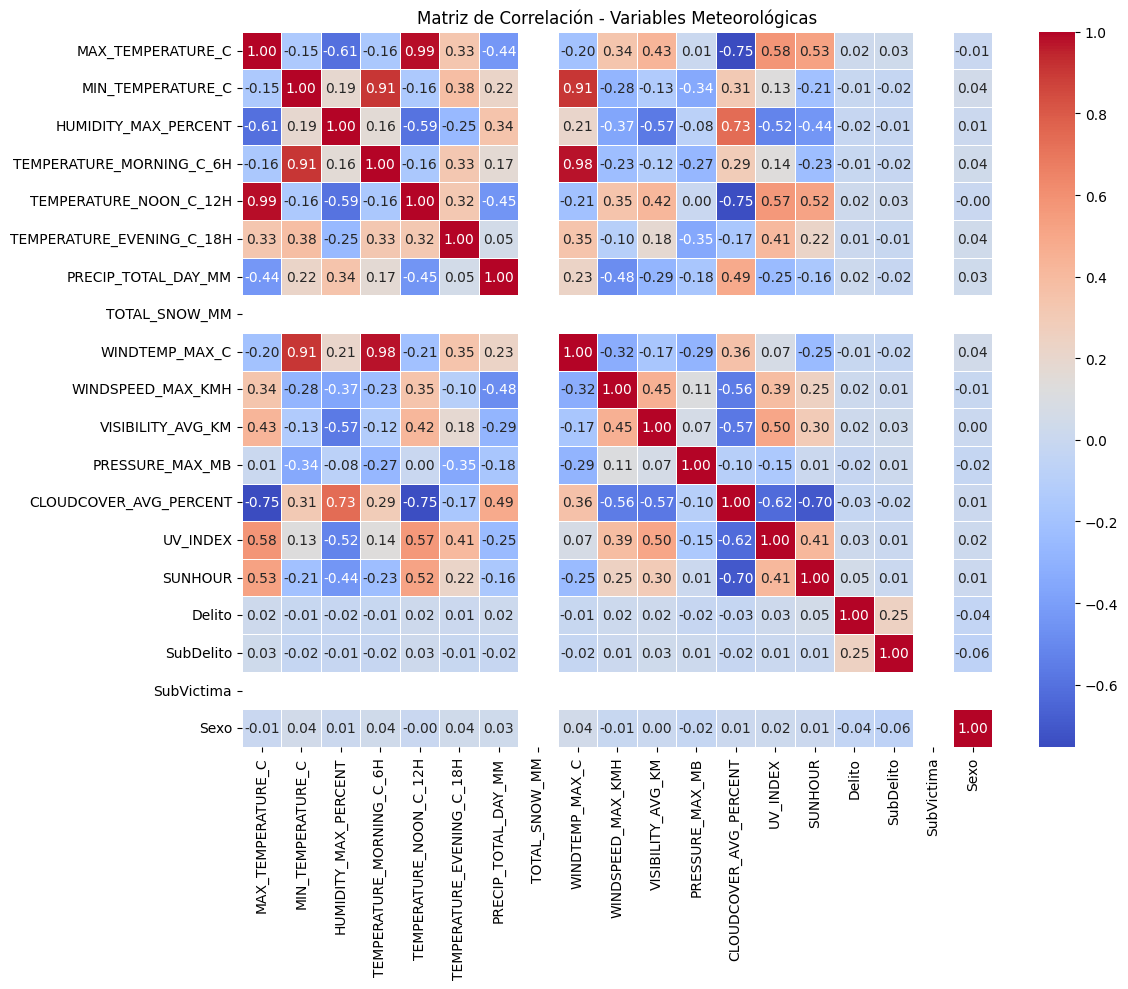

In [ ]:
features_meteo = [
    'MAX_TEMPERATURE_C',
    'MIN_TEMPERATURE_C',
    'HUMIDITY_MAX_PERCENT',
    'TEMPERATURE_MORNING_C_6H',
    'TEMPERATURE_NOON_C_12H',
    'TEMPERATURE_EVENING_C_18H',
    'PRECIP_TOTAL_DAY_MM',
    'TOTAL_SNOW_MM',
    'WINDTEMP_MAX_C',
    'WINDSPEED_MAX_KMH',
    'VISIBILITY_AVG_KM',
    'PRESSURE_MAX_MB',
    'CLOUDCOVER_AVG_PERCENT',
    'UV_INDEX',
    'SUNHOUR',
    'Delito',
    'SubDelito',
    'SubVictima',
    'Sexo'
]

# Filtrar el DataFrame
df_meteo = df_meteo_merge[features_meteo]

# Matriz de correlación
correlation_matrix = df_meteo.corr()

# Visualización
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación - Variables Meteorológicas')
plt.tight_layout()
plt.show()


# Primera Pista
Parece que el dataframe esta con clases de subdelito desbalanceado

In [ ]:
df_meteo_merge['Delito'].value_counts()

,count
Delito,
1,4672
2,3697
0,1750
3,2
4,1


# Primera prueba de arbol de desición
para corroborar sospechas de arbol desbalanceado

In [ ]:
# Filtrar solo las clases 0, 1 y 2
df_filtrado = df_meteo_merge[df_meteo_merge['Delito'].isin([0, 1, 2])].copy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Usa DecisionTreeRegressor si es regresión
from sklearn.metrics import classification_report

# Selección de features meteorológicas
features = [
    'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'HUMIDITY_MAX_PERCENT',
    'PRECIP_TOTAL_DAY_MM', 'WINDTEMP_MAX_C', 'SUNHOUR', 'CLOUDCOVER_AVG_PERCENT'
]

X = df_meteo_merge[features]
y = df_meteo_merge['Delito']  # Asegúrate de que esté codificado numéricamente

# Entrenamiento rápido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
modelo = DecisionTreeClassifier(max_depth=4)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.16      0.01      0.03       546
           1       0.46      0.91      0.61      1391
           2       0.37      0.08      0.13      1100

    accuracy                           0.45      3037
   macro avg       0.33      0.33      0.25      3037
weighted avg       0.37      0.45      0.33      3037



# Estdisticas de medicion
- El modelo casi no logra identificar esta clase. Muy bajo recall indica que la mayoría de los verdaderos casos clase 0 se clasifican mal.
- Excelente recall (91%), lo que significa que captura casi todos los verdaderos positivos, pero con precisión moderada: también predice clase 1 cuando no lo es.
- Bajo recall y precisión. Se le escapan muchos ejemplos reales de clase 2, y predice pocos correctamente.
cambio en el arbol para solo usar clases 1 y 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Filtrar las clases que te interesan
df_filtrado = df_meteo_merge[df_meteo_merge['Delito'].isin([1, 2])].copy()

# Selección de features meteorológicas
features = [
    'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'HUMIDITY_MAX_PERCENT',
    'PRECIP_TOTAL_DAY_MM', 'WINDTEMP_MAX_C', 'SUNHOUR', 'CLOUDCOVER_AVG_PERCENT'
]

X = df_filtrado[features]
y = df_filtrado['Delito']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify para mantener proporciones de clase
)

# Entrenamiento del modelo
modelo = DecisionTreeClassifier(max_depth=4)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)

# Evaluación
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.56      0.87      0.68      1402
           2       0.46      0.15      0.22      1109

    accuracy                           0.55      2511
   macro avg       0.51      0.51      0.45      2511
weighted avg       0.52      0.55      0.48      2511



# Segunda Prueba
aunque hubo una mejoria no parecia ser suficiente para desplegar el arbol de desicion
Proximo paso seria volver al original y ver balance

In [ ]:
modelo = DecisionTreeClassifier(max_depth=6, class_weight='balanced')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Filtrar las clases que te interesan
df_filtrado = df_meteo_merge[df_meteo_merge['Delito'].isin([0, 1, 2])].copy()

# Selección de features meteorológicas
features = [
    'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'HUMIDITY_MAX_PERCENT',
    'PRECIP_TOTAL_DAY_MM', 'WINDTEMP_MAX_C', 'SUNHOUR', 'CLOUDCOVER_AVG_PERCENT'
]

X = df_filtrado[features]
y = df_filtrado['Delito']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify para mantener proporciones de clase
)

# Entrenamiento del modelo
modelo = DecisionTreeClassifier(max_depth=4)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)

# Evaluación
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       525
           1       0.46      0.92      0.62      1402
           2       0.38      0.08      0.14      1109

    accuracy                           0.46      3036
   macro avg       0.28      0.34      0.25      3036
weighted avg       0.35      0.46      0.33      3036



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# tercera prueba
cambiar de variable de 'Delito' a 'SubDelito'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Revision de valores
hay clases que tienen datos de mayoria, sin embargo las 3 primeras estan cerca, por otro lado hay datos que rondan valores entre 800 y 120
otras son de 98 a menos valores, inclusive los que preocupan son las caterorias de subdelito que poseen solo un dato

In [ ]:
df_meteo_merge['SubDelito'].value_counts()

,count
SubDelito,
20,2932
13,1757
3,1414
6,762
19,737
0,642
12,420
10,356
24,218


# Prueba con valores
se escogieron las clases 20, 13, 3, 6, 19 y 0 para ver si poseeia una mejoria

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Filtrar las clases que te interesan
df_filtrado = df_meteo_merge[df_meteo_merge['SubDelito'].isin([20, 13, 3,6, 19, 0])].copy()

# Selección de features meteorológicas
features = [
    'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'HUMIDITY_MAX_PERCENT',
    'PRECIP_TOTAL_DAY_MM', 'WINDTEMP_MAX_C', 'SUNHOUR', 'CLOUDCOVER_AVG_PERCENT'
]

X = df_filtrado[features]
y = df_filtrado['SubDelito']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify para mantener proporciones de clase
)

# Entrenamiento del modelo
modelo = DecisionTreeClassifier(max_depth=4)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)

# Evaluación
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.22      0.01      0.02       193
           3       0.38      0.03      0.05       424
           6       0.00      0.00      0.00       229
          13       0.20      0.05      0.08       527
          19       0.00      0.00      0.00       221
          20       0.36      0.94      0.52       880

    accuracy                           0.35      2474
   macro avg       0.19      0.17      0.11      2474
weighted avg       0.25      0.35      0.21      2474



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Creacion de más Variables
comprendidas de la union de temperaturas, temperaturas y precipitacion, velocidad del viento y nubosidad

In [ ]:
df_meteo_merge['Amplitud_Termica'] = df_meteo_merge['MAX_TEMPERATURE_C'] - df_meteo_merge['MIN_TEMPERATURE_C']

In [ ]:
df_meteo_merge['Rango_Temp_Horaria'] = df_meteo_merge['TEMPERATURE_NOON_C_12H'] - df_meteo_merge['TEMPERATURE_MORNING_C_6H']

In [ ]:
df_meteo_merge['Indice_Extremo'] = (
    (df_meteo_merge['PRECIP_TOTAL_DAY_MM'] > 10).astype(int) +
    (df_meteo_merge['WINDSPEED_MAX_KMH'] > 50).astype(int) +
    (df_meteo_merge['CLOUDCOVER_AVG_PERCENT'] > 80).astype(int)
)

# creacion de caracteristica
con las caracteristicas de fecha y victima que compende ula hora del crimen, parece que no le dieron formato correcto a la hora de creacion del dataframe del oij

In [ ]:
import pandas as pd

# Asegurar que Date está en formato datetime
df_meteo_merge['Fecha'] = pd.to_datetime(df_meteo_merge['Date'])

# Convertir Victima a string y luego extraer la hora de inicio
df_meteo_merge['Hora_Inicio'] = df_meteo_merge['Victima'].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')

# Crear un timestamp completo
df_meteo_merge['Timestamp_Delito'] = pd.to_datetime(df_meteo_merge['Fecha'].dt.date.astype(str) + ' ' + df_meteo_merge['Hora_Inicio'])

In [ ]:
df_meteo_merge['Hora'] = df_meteo_merge['Timestamp_Delito'].dt.hour

# Crear rangos personalizados
df_meteo_merge['Franja_Horaria'] = pd.cut(
    df_meteo_merge['Hora'],
    bins=[0, 6, 12, 18, 24],
    labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'],
    right=False
)

# caracteristica de tipo de clima
para ver si se apoya en que dia estaba lloviendo fuerte o era noche lluviosa,
junto con las variables de dia de semana o fin de semana

In [ ]:
df_meteo_merge['Lluvia_Fuerte'] = (df_meteo_merge['PRECIP_TOTAL_DAY_MM'] > 10).astype(int)
df_meteo_merge['Noche_Lluviosa'] = (
    (df_meteo_merge['Franja_Horaria'] == 'Noche') & (df_meteo_merge['Lluvia_Fuerte'] == 1)
).astype(int)

In [ ]:
df_meteo_merge['Dia_Semana'] = df_meteo_merge['Timestamp_Delito'].dt.dayofweek  # 0 = lunes
df_meteo_merge['Es_FinDeSemana'] = df_meteo_merge['Dia_Semana'].isin([5,6]).astype(int)

In [ ]:
# Asegurar formato datetime
df_meteo_merge['Fecha'] = pd.to_datetime(df_meteo_merge['Date'])
df_meteo_merge['Hora_Inicio'] = df_meteo_merge['Victima'].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')
df_meteo_merge['Timestamp_Delito'] = pd.to_datetime(
    df_meteo_merge['Fecha'].dt.date.astype(str) + ' ' + df_meteo_merge['Hora_Inicio']
)

# Nuevas columnas
df_meteo_merge['Hora'] = df_meteo_merge['Timestamp_Delito'].dt.hour
df_meteo_merge['Dia_Semana'] = df_meteo_merge['Timestamp_Delito'].dt.dayofweek  # 0=lunes
df_meteo_merge['Es_FinDeSemana'] = df_meteo_merge['Dia_Semana'].isin([5,6]).astype(int)

# cuarta prueba
Para probar si estas nuevas caracteristicas sean un cambio en la presicion del modelo de ML

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Filtrar las clases que te interesan
df_filtrado = df_meteo_merge[df_meteo_merge['SubDelito'].isin([20, 13, 3,6, 19, 0])].copy()

# Selección de features meteorológicas
features = [
    'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'HUMIDITY_MAX_PERCENT',
    'PRECIP_TOTAL_DAY_MM', 'WINDTEMP_MAX_C', 'SUNHOUR', 'CLOUDCOVER_AVG_PERCENT',
    'Hora', 'Dia_Semana', 'Es_FinDeSemana'
]

X = df_filtrado[features]
y = df_filtrado['SubDelito']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify para mantener proporciones de clase
)

# Entrenamiento del modelo
# Árbol más profundo para capturar relaciones más complejas
modelo = DecisionTreeClassifier(max_depth=8, random_state=42)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)

# Evaluación
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.15      0.02      0.04       193
           3       0.32      0.14      0.19       424
           6       0.16      0.01      0.02       229
          13       0.29      0.12      0.17       527
          19       0.06      0.00      0.01       221
          20       0.37      0.85      0.52       880

    accuracy                           0.36      2474
   macro avg       0.23      0.19      0.16      2474
weighted avg       0.28      0.36      0.26      2474



# Cambio de modelo
Para ver si hay mejoria en el random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # ajustable
    class_weight='balanced',
    random_state=42
)
modelo.fit(X_train, y_train)
preds = modelo.predict(X_test)
# Evaluación
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.12      0.22      0.15       193
           3       0.34      0.36      0.35       424
           6       0.12      0.19      0.14       229
          13       0.26      0.23      0.24       527
          19       0.15      0.24      0.19       221
          20       0.43      0.25      0.32       880

    accuracy                           0.25      2474
   macro avg       0.24      0.25      0.23      2474
weighted avg       0.30      0.25      0.27      2474



In [ ]:
RandomForestClassifier(n_estimators=300, max_depth=10, class_weight='balanced')

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300)

# Proximos Pasos
- Probar un modelo de boosting (como XGBoost o LightGBM): pueden encontrar fronteras más finas entre clases.
- Reducir el número de clases o aplicar Overslamping(SOME) a las categorias de subdelito
- Crear variables más expresivas: como presencia de condiciones extremas, tipo de día, o combinaciones tipo "noche lluviosa".
